# Lab Animal Growth Prediction 

**Objective:**  
This project develops a **species-agnostic computational framework** to predict laboratory animal body weight from biological (`Age_weeks`, `Sex`, `Strain`) and environmental (`Diet`) factors using **regression models**. Current validation is performed in mice, with extension to other species achievable through retraining on their datasets.


<div style="text-align:center;">
  <img src="https://trulynolen.ca/wp-content/uploads/2022/11/Mother-Mice-do-to-Protect-Babies-750.png" style="width:100%; max-width:1000px; height:auto;" />
  <div style="font-size:0.9em; margin-top:5px;">Image courtesy of Truly Nolen</div>
</div>

**Why Mice for this Project?**  
Mice are the **most widely used laboratory animals** due to:  
- Well-characterized genetics and strains (C57BL/6, BALB/c, FVB/N, etc.)  
- Short lifecycle and rapid growth, which allows longitudinal studies  
- Extensive historical data, making synthetic and real datasets easy to model  
- High translational value for biomedical research  

By starting with mice, this project creates a **reproducible template** that can be extended to other lab animals (rats, guinea pigs, rabbits, non-human primates, etc.).  

**Task Type:**  
- Regression – predicting a continuous outcome (weight in grams).  

**Dataset:**  
- Synthetic dataset (~1,000 mice) including:  
  - `Age_weeks`  
  - `Sex` (M/F)  
  - `Strain` (common lab strains)  
  - `Diet` (Low, Medium, High)  
- The dataset is **saved for reproducibility** (`mouse_growth.csv`).  

**Methods & Tools:**  
- **Data handling:** `pandas`, `numpy`  
- **Visualization:** `matplotlib`, `seaborn`  
- **Machine Learning:** `scikit-learn` (Linear Regression, Decision Tree, Cross-Validation)  
- **Model persistence:** `joblib` (trained models saved for reuse)  

**Veterinary Relevance:**  
Modeling weight trajectories mirrors real-world laboratory animal research, where understanding growth is critical. Applications include:  
- Monitoring growth patterns over time  
- Evaluating strain × diet interactions  
- Capturing non-linear age effects (e.g., rapid early growth followed by plateau)  

**Reproducibility:**  
- Trained models are **saved for future use**, allowing predictions without retraining.  
- The CSV dataset ensures others can **recreate feature engineering, train/test splits, and analyses**.  

> This project bridges **ML modeling** and **biological interpretation**, demonstrating both technical and veterinary insights, with a focus on **reproducible research practices**.


## Step 1: Importing Libraries

We begin by importing essential Python libraries for **data manipulation, visualization, and machine learning**:

- **numpy** → numerical computations, arrays, and mathematical operations  
- **pandas** → data handling, DataFrames, and preprocessing  
- **matplotlib & seaborn** → plotting, visual exploration, and enhanced figure aesthetics  
- **scikit-learn (sklearn)** → machine learning models, regression, evaluation metrics, and preprocessing tools  
- **joblib** → efficiently save and load trained models  
- **os** → interacting with the file system (e.g., paths, directories)  
- **warnings** → suppress unnecessary warnings for cleaner notebook output  

> These libraries provide a solid foundation for any Python ML workflow, enabling us to efficiently process, explore, model, and interpret our data.


In [348]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import PolynomialFeatures
import joblib
import os
import warnings
warnings.filterwarnings("ignore")

## Step 2: Dataset Fields

- **AnimalID**: Unique identifier for each mouse  
- **Age_weeks**: Age of the mouse in weeks (1–12 weeks)  
- **Sex**: Male or Female  
- **Strain**: Mouse strain (`C57BL/6`, `BALB/c`, `DBA/2`, `129/Sv`, `FVB/N`)  
- **Diet**: High, Medium, or Low  
- **Weight_g**: Mouse body weight in grams (**target variable**)  

**Notes for Researchers:**  
- The dataset simulates **1,000 mice**, but the framework is highly flexible.  
- The number of animals, **strains, ages, and other experimental groups** can be easily adjusted.  
- Additional features (e.g., husbandry conditions, environmental enrichment, clinical markers) can be incorporated.  
- This approach can be adapted to other **species** (rats, rabbits, nonhuman primates, etc.) by redefining the feature set accordingly.  


In [350]:
strains = ['C57BL/6', 'BALB/c', 'DBA/2', '129/Sv', 'FVB/N']
sexes = ['M', 'F']
diets = ['Low', 'Medium', 'High']

## Step 3: Generating Synthetic Mouse Dataset

We will create a dataset of **1,000 mice** with the following features:

- **Age_weeks**: 1–12 weeks  
- **Sex**: Male or Female  
- **Strain**: Common research strains (`C57BL/6`, `BALB/c`, `DBA/2`, `129/Sv`, `FVB/N`)  
- **Diet**: Low, Medium, or High  
- **Weight_g**: Mouse body weight in grams  

The weights are generated to **reflect realistic growth patterns**, influenced by age, strain, sex, and diet. This synthetic dataset will serve as a controlled foundation for **training and evaluating regression models**, while demonstrating biologically meaningful variability.


In [352]:
np.random.seed(42) # Ensuring Reproducibility

n_mice = 1000

# Randomly assigning Age, Sex, Strain, Diet
ages = np.random.randint(1, 13, size=n_mice) # 1-12 weeks
sexes_random = np.random.choice(sexes, size=n_mice)
strains_random = np.random.choice(strains, size=n_mice)
diets_random = np.random.choice(diets, size=n_mice)
# Biological/Vet Note: You can easily adjust ages, strains, diets, or add more features
# for different species or experimental designs.

In [353]:
# Create the DataFrame
df = pd.DataFrame({
    'AnimalID': range(1, n_mice+1),
    'Age_weeks': ages,
    'Sex': sexes_random,
    'Strain': strains_random,
    'Diet': diets_random
})
df

,AnimalID,Age_weeks,Sex,Strain,Diet
0,1,7,F,FVB/N,Medium
1,2,4,F,FVB/N,Low
2,3,11,F,129/Sv,Low
3,4,8,M,BALB/c,Low
4,5,5,F,FVB/N,Medium
...,...,...,...,...,...
995,996,6,M,129/Sv,High
996,997,5,F,DBA/2,Medium
997,998,6,F,129/Sv,High
998,999,6,F,DBA/2,High


## Step 4: Calculating Mouse Weights

We generate the `Weight_g` variable using the following formula:

Weight_g = Base_weight_for_age + Strain_effect + Sex_effect + Diet_effect + Random_noise

- **Base_weight_for_age**: linear growth from ~5 g at week 1 to ~30 g at week 12  
- **Strain_effect**: small adjustments depending on the mouse strain  
- **Sex_effect**: males +1–2 g, females +0 g  
- **Diet_effect**: High +2 g, Medium +0 g, Low -2 g  
- **Random_noise**: small random variation to simulate individual differences  

This formula captures **realistic biological variability** while keeping the dataset controlled for regression modeling. It ensures that growth patterns reflect age, sex, strain, and diet effects in a biologically meaningful way, which will be used later to train and evaluate regression models.


In [355]:
# 1- Base weight per week (linear approximation 1-12 weeks):
def base_weight(age):
    return 5 + (age - 1) * 2 # starts ~5g, increases 2g per week

# 2- Strain effects (grams):
strain_effects = {
    'C57BL/6': 0,
    'BALB/c': -1,
    'DBA/2': -2,
    '129/Sv': 1,
    'FVB/N': 2
}

# 3- Sex effects:
sex_effects = {
    'M': 1,
    'F': 0
}

# 4- Diet effects:
diet_effects = {
    'Low': -2,
    'Medium': 0,
    'High': 2
}

In [356]:
# Defining a Fucntion to Calculate the Weight
def calculate_weight(row):
    weight = base_weight(row['Age_weeks'])
    weight += strain_effects[row['Strain']]
    weight += sex_effects[row['Sex']]
    weight += diet_effects[row['Diet']]

    # Add biological noise:
    # σ = 0.5 g → closer to real mouse variability (< ±1.5 g), but causes overfitting (R² ≈ 1.0).
    # σ = 1.0 g → adds more spread (~±3 g), prevents perfect fits, better for modeling here.
    weight += np.random.normal(0, 1)

    return weight

# Applying the Function to the DataFrame
df['Weight_g'] = df.apply(calculate_weight, axis=1)
df.head()

,AnimalID,Age_weeks,Sex,Strain,Diet,Weight_g
0,1,7,F,FVB/N,Medium,19.965397
1,2,4,F,FVB/N,Low,12.236131
2,3,11,F,129/Sv,Low,24.088658
3,4,8,M,BALB/c,Low,17.197316
4,5,5,F,FVB/N,Medium,14.382348


## Step 5: Visualizing Mouse Growth

We explore the dataset using the following plots:

1. **Scatter plot:** Age vs Weight (all mice)  
2. **Scatter plot:** Age vs Weight by Strain (color-coded)  
3. **Scatter plot:** Age vs Weight by Sex (color-coded)  
4. **Scatter plot:** Age vs Weight by Diet (color-coded)  

**Purpose of visualization:**  
- Understand overall growth trends  
- Identify differences between groups (Strain, Sex, Diet)  
- Detect unrealistic values or excessive noise  
- Provide an intuitive sense of how age, sex, strain, and diet influence weight  

> Visual inspection ensures the synthetic dataset behaves biologically and supports informed model training.


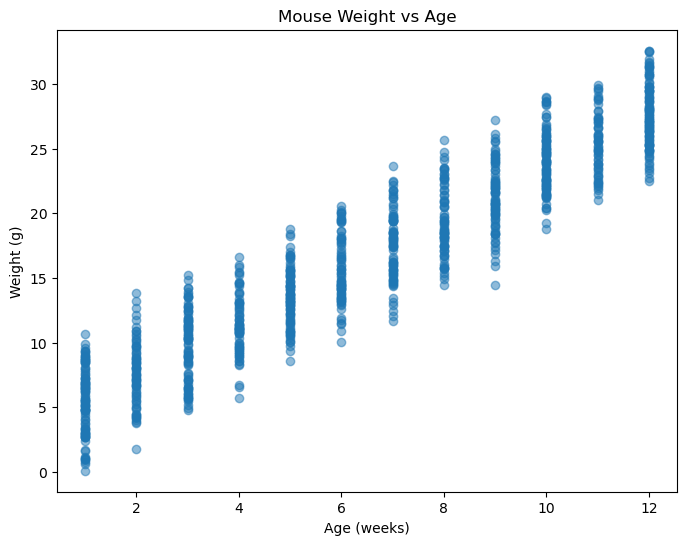

In [358]:
plt.figure(figsize=(8, 6))
plt.scatter(df['Age_weeks'], df['Weight_g'], alpha=0.5)
plt.title('Mouse Weight vs Age')
plt.xlabel('Age (weeks)')
plt.ylabel('Weight (g)')
plt.show()

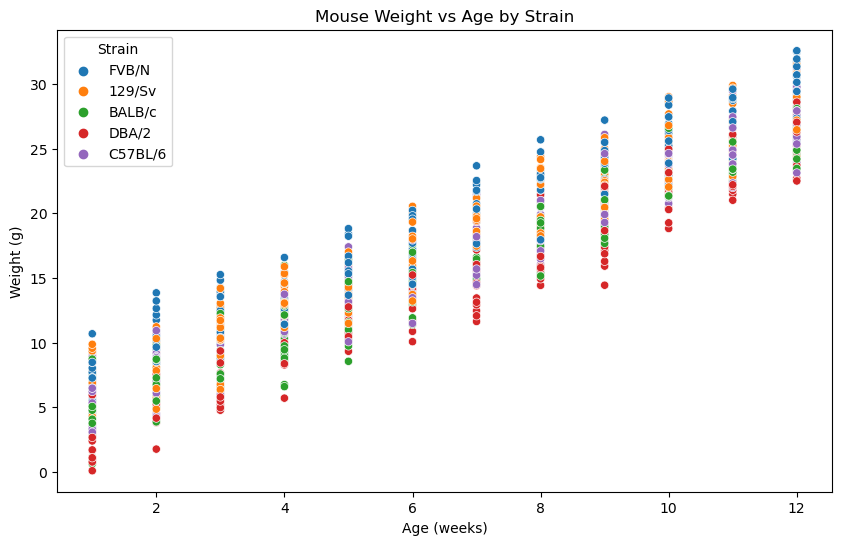

In [359]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age_weeks', y='Weight_g', hue='Strain')
plt.title('Mouse Weight vs Age by Strain')
plt.xlabel('Age (weeks)')
plt.ylabel('Weight (g)')
plt.show()

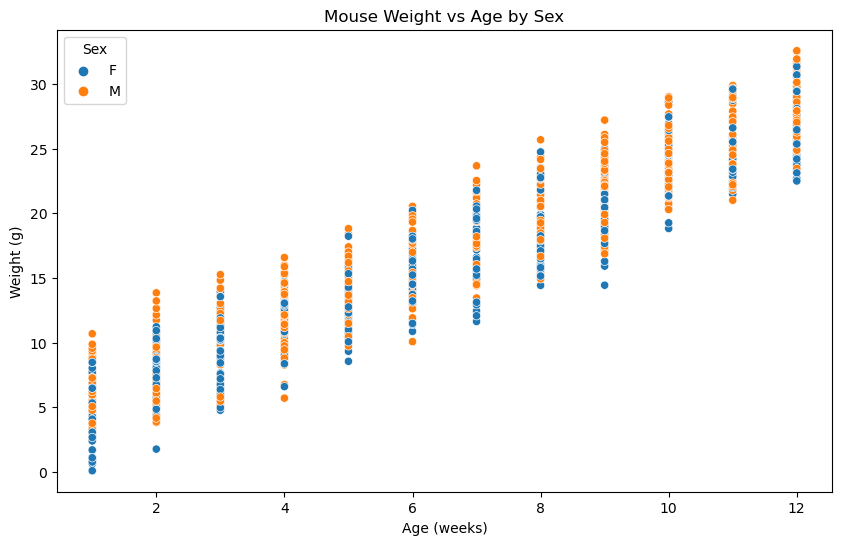

In [360]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Age_weeks', y='Weight_g', hue='Sex')
plt.title('Mouse Weight vs Age by Sex')
plt.xlabel('Age (weeks)')
plt.ylabel('Weight (g)')
plt.show()

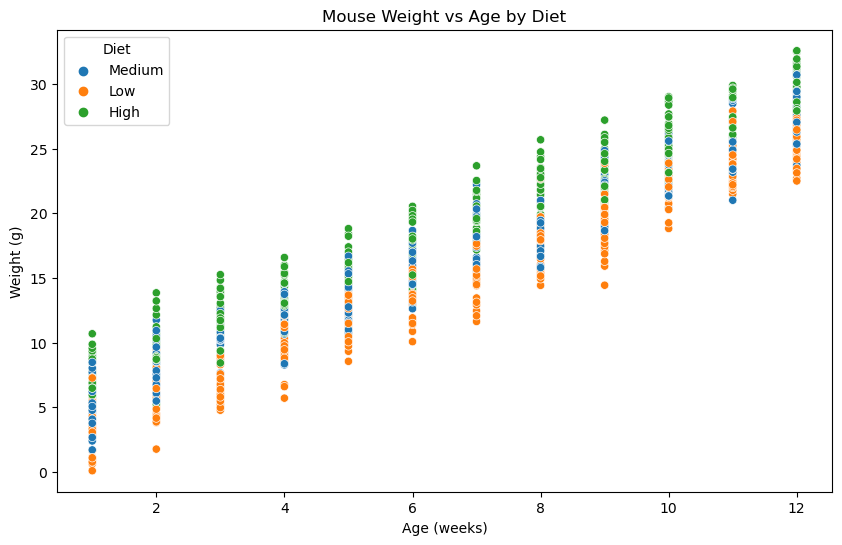

In [361]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x= 'Age_weeks', y='Weight_g', hue='Diet')
plt.title('Mouse Weight vs Age by Diet')
plt.xlabel('Age (weeks)')
plt.ylabel('Weight (g)')
plt.show()

## Step 6: Preprocessing for Machine Learning

Before training regression models, we must **prepare the dataset**:

1. **Encode categorical variables** (`Sex`, `Strain`, `Diet`) using **one-hot encoding** so that the model can interpret them numerically.  
2. **Keep `Age_weeks` as numeric**, since it is already a continuous predictor.  
3. **Set `Weight_g` as the target variable** for regression.  
4. **Inspect the dataset** by checking its shape and the first few rows to ensure preprocessing worked correctly.  

This step ensures that all predictors are in a format suitable for regression, while maintaining biological interpretability.

> **NOTICE (Baseline categories):**  
> - Strain = `129/Sv`  
> - Diet = `High`  
> - Sex = `Female`  
>
> **Explanation:** These baseline categories are the “reference” levels for one-hot encoded variables.  
> All other categories are compared against them when interpreting model coefficients.  
> For example, if `Strain_BALB/c = -1.8`, it means BALB/c mice weigh ~1.8 g less than the baseline strain (129/Sv), holding other factors constant.  
> This ensures clarity when reading coefficients and makes the results **vet-friendly** for interpretation.


In [363]:
X = pd.get_dummies(df[['Age_weeks', 'Sex', 'Strain', 'Diet']], drop_first=True)
y = df['Weight_g']
X.head()

,Age_weeks,Sex_M,Strain_BALB/c,Strain_C57BL/6,Strain_DBA/2,Strain_FVB/N,Diet_Low,Diet_Medium
0,7,False,False,False,False,True,False,True
1,4,False,False,False,False,True,True,False
2,11,False,False,False,False,False,True,False
3,8,True,True,False,False,False,True,False
4,5,False,False,False,False,True,False,True


In [364]:
# One-hot encode Sex, Strain, Diet
X = pd.get_dummies(df[['Age_weeks', 'Sex', 'Strain', 'Diet']], drop_first=True) 

X = X.astype(int) # converting True/False to 1/0

# Target variable
y = df['Weight_g']

X.head()

,Age_weeks,Sex_M,Strain_BALB/c,Strain_C57BL/6,Strain_DBA/2,Strain_FVB/N,Diet_Low,Diet_Medium
0,7,0,0,0,0,1,0,1
1,4,0,0,0,0,1,1,0
2,11,0,0,0,0,0,1,0
3,8,1,1,0,0,0,1,0
4,5,0,0,0,0,1,0,1


## Step 7: Train/Test Split & Linear Regression

**Objective:**  
- Train a Linear Regression model to predict mouse weight.  
- Evaluate performance on **training and test sets**.  

**Steps:**  
1. Split the dataset into **training (80%)** and **testing (20%)** sets.  
2. Fit a **Linear Regression model** on the training data.  
3. Predict weights on training and testing sets.  
4. Compute performance metrics: **R²**, **MAE**, **RMSE**.  
5. Inspect coefficients to **interpret biological effects**.  
6. Visualize **actual vs predicted weights** and residuals.  

**Notes for Researchers:**  
- Dropped categories in one-hot encoding act as **baseline references**: Strain = `129/Sv`, Diet = `High`, Sex = `Female`.  
- Coefficients show expected change compared to baseline, e.g., `Strain_BALB/c = -1.1` → BALB/c mice weigh ~1.1 g less than 129/Sv, holding other factors constant.


In [366]:
# Splitting our Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (800, 8)
X_test shape: (200, 8)
y_train shape: (800,)
y_test shape: (200,)


In [367]:
# Fitting/Training the  model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on training and test(unseen) sets
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
# Metrics (Evaluating the model performance)

# 1- Train metrics

# R² score → "How much of the variance in y_test does the model explain?"
# Intrepretation: R² tells us how much of the weight differences between mice
train_r2  = r2_score(y_train, y_train_pred)

# MAE → "On average, how far off (in grams) are my predictions?"
train_mae = mean_absolute_error(y_train, y_train_pred)

# RMSE → "Typical error size, but large mistakes get punished more"
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# 2- Test metrics
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Linear Regression (Train): R²: {train_r2:.2f}, MAE: {train_mae:.2f} g, RMSE: {train_rmse:.2f} g")
print(f"Linear Regression (Test) :  R²: {test_r2:.2f}, MAE: {test_mae:.2f} g, RMSE: {test_rmse:.2f} g")

Linear Regression (Train): R²: 0.98, MAE: 0.77 g, RMSE: 0.96 g
Linear Regression (Test) :  R²: 0.98, MAE: 0.82 g, RMSE: 1.04 g


In [368]:
# Feature importance based on absolute value of coefficients
feature_importance_lr = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lr.coef_
}).sort_values(
    by='Importance',
    key=lambda col:col.abs(),
    ascending=False
)

# Creating the Biological Interpretation Column
feature_importance_lr['Biological Interpretation'] = [
    '→weight decreases ~3.99 g vs baseline',
    '→weight decreases ~2.99 g vs baseline',
    '→weight decreases ~2.07 g vs baseline',
    '→weight increases ~1.98 g vs baseline',
    '→weight decreases ~1.78 g vs baseline',
    '→weight increases ~1.07 g vs baseline',
    '→weight increases ~0.96 g vs female',
    '→weight decreases ~0.76 g vs baseline'
]

# NOTICE: Baseline mouse = 129/Sv, High diet, Female

feature_importance_lr.reset_index(drop=True, inplace=True)
feature_importance_lr

,Feature,Importance,Biological Interpretation
0,Diet_Low,-4.101781,→weight decreases ~3.99 g vs baseline
1,Strain_DBA/2,-3.204217,→weight decreases ~2.99 g vs baseline
2,Diet_Medium,-2.097901,→weight decreases ~2.07 g vs baseline
3,Age_weeks,2.006168,→weight increases ~1.98 g vs baseline
4,Strain_BALB/c,-1.896451,→weight decreases ~1.78 g vs baseline
5,Sex_M,1.086290,→weight increases ~1.07 g vs baseline
6,Strain_C57BL/6,-1.056476,→weight increases ~0.96 g vs female
7,Strain_FVB/N,0.970711,→weight decreases ~0.76 g vs baseline


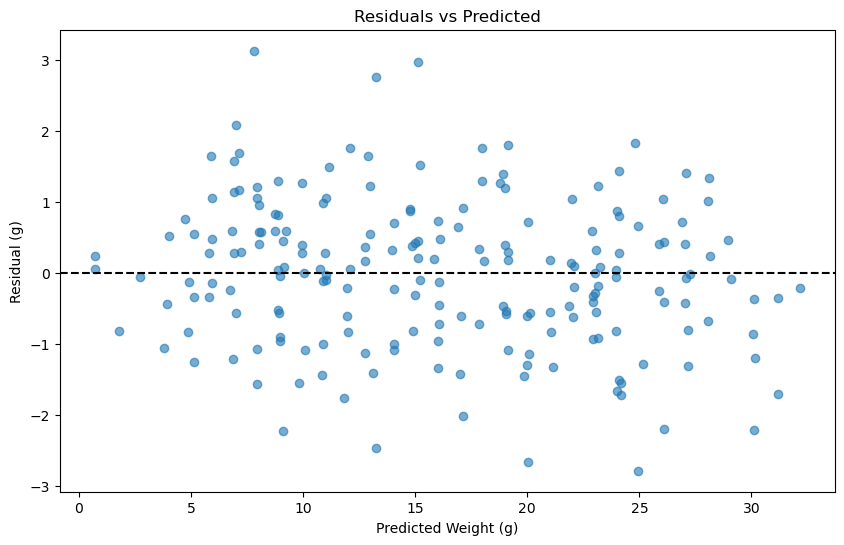

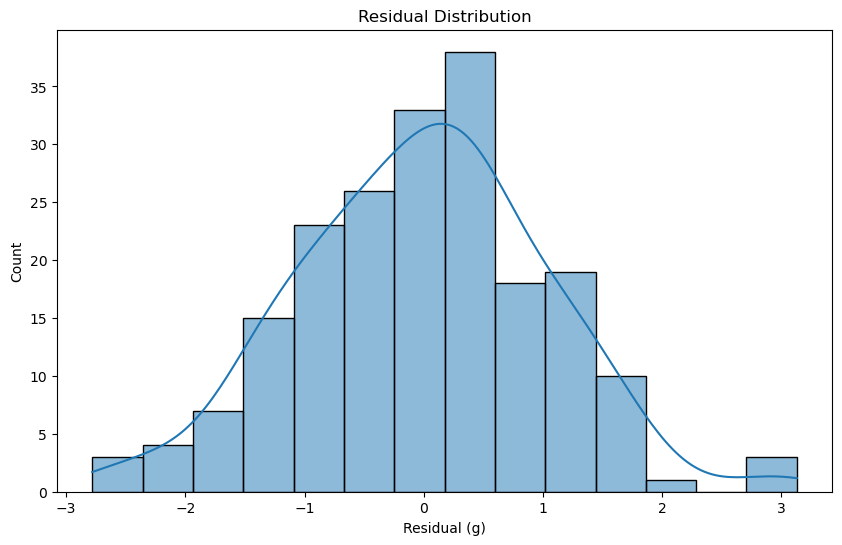

In [369]:
### Calculating the residuals
residuals = y_test - y_test_pred

# Residuals vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Predicted Weight (g)')
plt.ylabel('Residual (g)')
plt.title('Residuals vs Predicted')
plt.show()

# Residual distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residual (g)')
plt.title('Residual Distribution')
plt.show()

# Biological Note & ML Interpretation – Residuals and Coefficients

### Residuals
- **Residual = Actual weight − Predicted weight**  
- Points near **0** → model prediction is accurate  
- **Positive residual** → mouse is heavier than expected  
- **Negative residual** → mouse is lighter than expected  
- Spread (~±σ) reflects natural **biological variability** in the dataset  

### Linear Regression Coefficients
- `Age_weeks` → expected weight gain per week  
- One-hot categorical coefficients → difference compared to **baseline category**  
- **Positive coefficient** → feature increases weight  
- **Negative coefficient** → feature decreases weight  
- Baseline categories (dropped) serve as the **reference group**  
- Residuals ≈ 0 → model fits well  
- Patterned residuals → may indicate **nonlinearity** or missing interactions


## Step 8: Decision Tree Regression

**Objective:**  
- Explore a **nonlinear model** (Decision Tree Regressor) to predict mouse weight.  
- Capture **interactions and nonlinear growth trends**, such as age-dependent growth differences by strain or diet.

**Steps:**  
1. Fit a **Decision Tree Regressor** on the training data.  
2. Predict weights for **training** and **testing** sets.  
3. Evaluate performance using **R²** and **MAE**, comparing with Linear Regression.  
4. Inspect **feature importances** to identify influential predictors.  
5. Visualize predictions vs. actuals or residuals if needed.

**Biological relevance:**  
- Some mouse strains grow quickly in early weeks but plateau later; diet effects may also be nonlinear.  
- Decision trees model these **biological nuances naturally**, without manually creating interaction or polynomial features.  
- Facilitates understanding of which factors most influence growth trajectories in a flexible, data-driven way.


In [372]:
# Initialize and fit Decision Tree
dt = DecisionTreeRegressor(random_state=42, max_depth=6) # limiting the depth to prevent huge overfitting
dt.fit(X_train, y_train)

#Predict on training and test sets
y_train_dt = dt.predict(X_train)
y_test_dt = dt.predict(X_test)

# Metrics:-

# 1- Train Metrics
train_r2_dt = r2_score(y_train, y_train_dt)
train_mae_dt = mean_absolute_error(y_train, y_train_dt)
train_rmse_dt = np.sqrt(mean_squared_error(y_train, y_train_dt))
                        
# 2- Test Metrics
test_r2_dt = r2_score(y_test, y_test_dt)
test_mae_dt = mean_absolute_error(y_test, y_test_dt)
test_rmse_dt = np.sqrt(mean_squared_error(y_test, y_test_dt))

print(f'Decision Tree (Train): R2: {train_r2_dt:.2f}, MAE: {train_mae_dt:.2f} g, RMSE: {train_rmse_dt:.2f} g')
print(f'Decsion Tree  (Test) : R2: {test_r2_dt:.2f}, MAE: {test_mae_dt:.2f} g, RMSE: {test_rmse_dt:.2f} g')

Decision Tree (Train): R2: 0.96, MAE: 1.18 g, RMSE: 1.47 g
Decsion Tree  (Test) : R2: 0.95, MAE: 1.36 g, RMSE: 1.68 g


In [373]:
# Feature importance based on absolute value of coefficients
feature_importance_dt = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt.feature_importances_
}).sort_values('Importance', ascending=False)


# Creating the Biological Interpretation Column
feature_importance_dt['Biological Interpretation'] = [
    '→ primary driver of weight gain in mice',
    '→ slightly affects weight vs to baseline diet',
    '→ minor influence on weight',
    '→ minor influence on weight',
    '→ minor influence on weight',
    '→ very small effect on weight',
    'strain → minimal effect',
    '→ no effect used by tree'
]

# NOTICE: Baseline mouse = 129/Sv, High diet, Female

feature_importance_dt.reset_index(drop=True, inplace=True)
feature_importance_dt   #Importance: how much the decision tree relied on that feature to make splits and reduce error.

,Feature,Importance,Biological Interpretation
0,Age_weeks,0.927043,→ primary driver of weight gain in mice
1,Diet_Low,0.039051,→ slightly affects weight vs to baseline diet
2,Strain_DBA/2,0.010792,→ minor influence on weight
3,Strain_FVB/N,0.010276,→ minor influence on weight
4,Diet_Medium,0.009619,→ minor influence on weight
5,Strain_BALB/c,0.002271,→ very small effect on weight
6,Sex_M,0.000947,strain → minimal effect
7,Strain_C57BL/6,0.000000,→ no effect used by tree


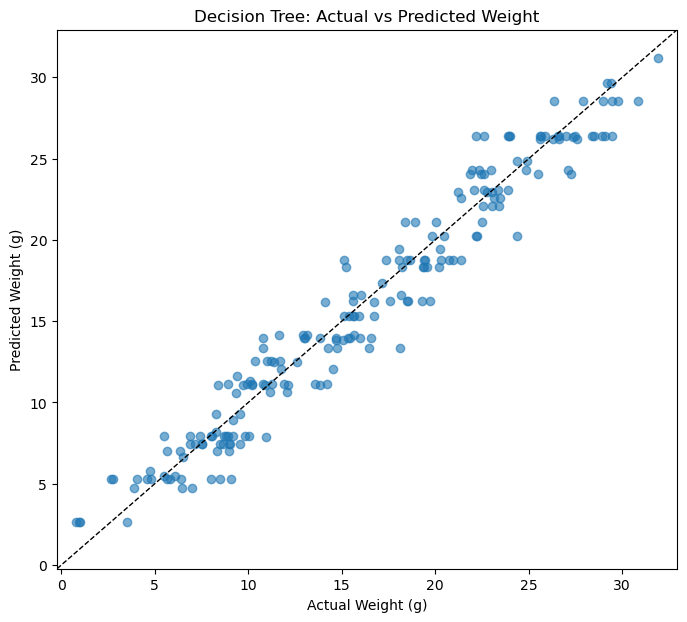

In [374]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 7))
plt.scatter(y_test, y_test_dt, alpha=0.6)
lims = [min(min(y_test), min(y_test_dt))-1, max(max(y_test), max(y_test_dt))+1]
plt.plot(lims, lims, '--', color='k', linewidth=1)
plt.xlabel('Actual Weight (g)')
plt.ylabel('Predicted Weight (g)')
plt.title('Decision Tree: Actual vs Predicted Weight')
plt.xlim(lims)
plt.ylim(lims)
plt.show()

### Note for Researchers – Interpreting Actual vs Predicted Scatter Plot

- **Points near the dashed line** → model predictions are accurate  
- **Above the line** → model overestimates weight (predicts heavier than actual)  
- **Below the line** → model underestimates weight (predicts lighter than actual)  

> Use this guidance when examining scatter plots to assess model performance from a veterinary perspective.


## Step 9: Cross-Validation & Model Comparison

**Objective:**  
- Apply **K-Fold Cross-Validation** to robustly evaluate Linear Regression and Advanced Linear Regression models.  
- Compare performance metrics (**R²**, **MAE**) across folds.  
- Identify **overfitting or underfitting** more reliably than a single train/test split.

**Biological/ML Rationale:**  
- In lab experiments, mice are rarely tested in a single batch; we need **generalizable results**.  
- Cross-validation simulates training and testing on multiple “batches” of mice.  
- Ensures model predictions **generalize across different groups, strains, diets, and ages**.

**Plan:**  
1. Select the number of folds (e.g., K=5).  
2. For each fold:  
   - Split data into training and validation sets.  
   - Fit the model on the training set.  
   - Predict weights on the validation set.  
   - Record **R²** and **MAE**.  
3. Compute **mean and standard deviation** of metrics across folds.  
4. Compare models to determine which approach generalizes best.


In [377]:
# Number of folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
print(f'K-Fold Cross-Validation with {k} folds')

K-Fold Cross-Validation with 5 folds


In [378]:
# Defining scoring functions
r2_scorer = make_scorer(r2_score)
mae_scorer = make_scorer(mean_absolute_error)

# Linear Regression (original features)
lr = LinearRegression()

# Cross-validation R²
# R² = how much weight variation is explained by age, strain, diet, sex.
r2_scores = cross_val_score(lr, X, y, cv=kf, scoring=r2_scorer)

# MAE = average prediction error in grams (e.g. MAE=2 → model is ~2 g off per mouse).
mae_scores = -cross_val_score(lr, X, y, cv=kf, scoring=make_scorer(mean_absolute_error))# negate because sklearn maximizes

print("Linear Regression CV Results:")
print(f"Mean R²: {r2_scores.mean():.2f}, Std: {r2_scores.std():.2f}")
print(f"Mean MAE: {mae_scores.mean():.2f} g, Std: {mae_scores.std():.2f} g")

Linear Regression CV Results:
Mean R²: 0.98, Std: 0.00
Mean MAE: -0.79 g, Std: 0.02 g


In [379]:
# Feature Engineering
# Making polynomial + interaction features up to degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Getting feature names for interpretation
feature_names = poly.get_feature_names_out(X.columns)

# Turning back into DataFrame for readability
X_poly = pd.DataFrame(X_poly, columns=feature_names)
X_poly

,Age_weeks,Sex_M,Strain_BALB/c,Strain_C57BL/6,Strain_DBA/2,Strain_FVB/N,Diet_Low,Diet_Medium,Age_weeks^2,Age_weeks Sex_M,...,Strain_DBA/2^2,Strain_DBA/2 Strain_FVB/N,Strain_DBA/2 Diet_Low,Strain_DBA/2 Diet_Medium,Strain_FVB/N^2,Strain_FVB/N Diet_Low,Strain_FVB/N Diet_Medium,Diet_Low^2,Diet_Low Diet_Medium,Diet_Medium^2
0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,49.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,4.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,16.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,11.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,121.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,8.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,64.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,25.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,5.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,25.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,36.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Notes for Researchers – Understanding Polynomial & Interaction Features

- **Polynomial features (degree=2)**: Squared terms of each predictor  
  - Example: `Age_weeks^2` → captures non-linear growth trends (weight gain may accelerate or plateau with age)  
- **Interaction features**: Products of two predictors  
  - Example: `Age_weeks * Diet_Low` → shows how the effect of age on weight depends on diet  
- These features allow the model to **capture complex biological relationships** without manually coding rules  
- DataFrame looks “scary” because each new column represents a combination or square of original features, but it makes the model more flexible and biologically informed


In [381]:
# Advanced Linear Regression with polynomial + interaction features
lr_poly = LinearRegression()

# Cross-validation R²
r2_scores_poly = cross_val_score(lr_poly, X_poly, y, cv=kf, scoring=r2_scorer)
mae_scores_poly = -cross_val_score(lr_poly, X_poly, y, cv=kf, scoring=make_scorer(mean_absolute_error))

print("Advanced Linear Regression CV Results:")
print(f"Mean R²: {r2_scores_poly.mean():.2f}, Std: {r2_scores_poly.std():.2f}")
print(f"Mean MAE: {mae_scores_poly.mean():.2f} g, Std: {mae_scores_poly.std():.2f} g")

Advanced Linear Regression CV Results:
Mean R²: 0.98, Std: 0.00
Mean MAE: -0.81 g, Std: 0.03 g


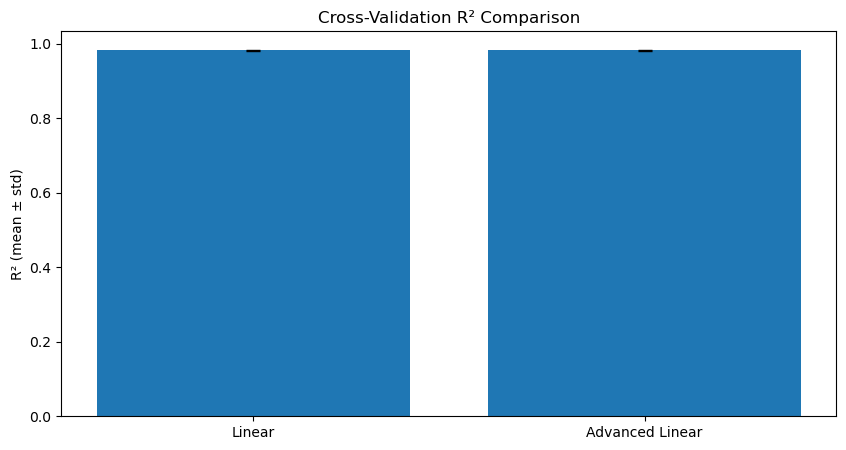

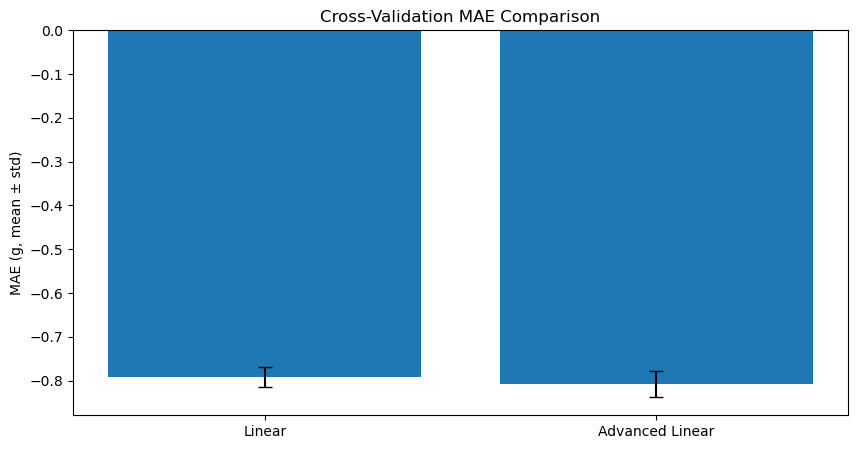

In [382]:
# Compare Linear vs Advanced Linear Regression Models
# ---------------------------------------------------

# 1. Define models: Linear vs Advanced Linear
models = ['Linear', 'Advanced Linear']

# 2. Collect mean + std for R² and MAE from cross-validation
# NOTE: R² tells us how much of weight growth we can explain with the model.

r2_means = [r2_scores.mean(), r2_scores_poly.mean()]
r2_std = [r2_scores.std(), r2_scores_poly.std()]

# - MAE tells us, on average, how many grams off our predictions are.
mae_means = [mae_scores.mean(), mae_scores_poly.mean()]
mae_std = [mae_scores.std(), mae_scores_poly.std()]


# Plot R² comparison
plt.figure(figsize=(10,5))
plt.bar(models, r2_means, yerr=r2_std, capsize=5)
plt.ylabel("R² (mean ± std)")
plt.title("Cross-Validation R² Comparison")
plt.show()

# Plot MAE comparison
plt.figure(figsize=(10,5))
plt.bar(models, mae_means, yerr=mae_std, capsize=5)
plt.ylabel("MAE (g, mean ± std)")
plt.title("Cross-Validation MAE Comparison")
plt.show()

# If Advanced Linear has higher R² and lower MAE → it captures growth patterns better.

> **Note for Researchers::** Both the simple and advanced regression models predict mouse weight comparably well.  
> This indicates that growth in these laboratory mice is largely **linear with age**, with diet and strain contributing predictable shifts in weight.  
> In practical terms: mice gain weight steadily over time, and differences due to diet or strain manifest as consistent adjustments rather than complex nonlinear patterns.


## Step 10: Saving Outputs for Reproducibility

**Objective:**  
- Ensure collaborators or future users can access the dataset and trained models without retraining.  
- Maintain a reproducible and shareable workflow.  

**What is Saved:**  
1. **Synthetic Dataset:** `mouse_growth.csv` – can be used to recreate features or rerun analyses.  
2. **Trained Models:**  
   - Linear Regression → `linear_regression_mouse_model.pkl`  
   - Decision Tree → `decision_tree_mouse_model.pkl`  

**Notes for Researchers:**  
- Intermediate feature-engineered datasets (polynomial or interaction features) are **not saved**, as they can be regenerated from the CSV.  
- Saved models can be loaded to make predictions directly on new data.  
- This approach ensures consistency, reproducibility, and ease of collaboration.  

> **Next Step:** In the final cell, we will confirm that the saved models work correctly by loading them and making test predictions.

In [385]:
# Making sure directories exist
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)

Linear Regression predictions sample: [22.94484858 11.99412992 22.08156683  9.96465489 17.96180186]
Decision Tree predictions sample: [22.82970005 11.41346873 21.96515243 10.59228144 18.16199798]
Linear Regression → R²: 0.98, MAE: 0.82 g, RMSE: 1.04 g
Decision Tree → R²: 0.96, MAE: 1.12 g, RMSE: 1.46 g


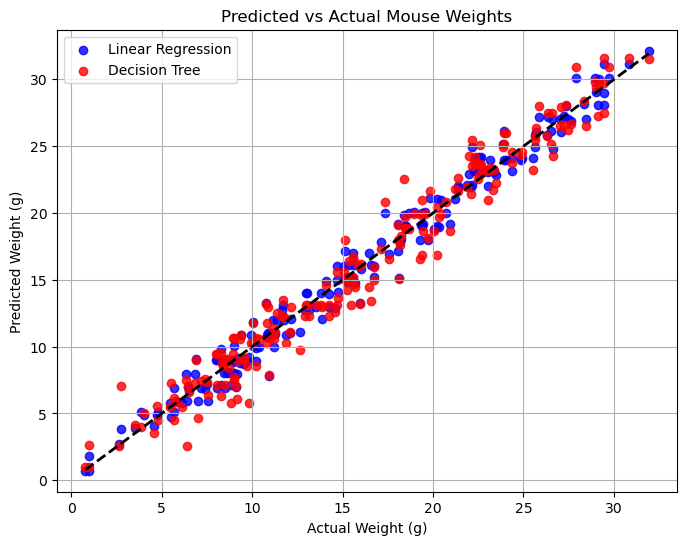

In [386]:
# =========================================
# Mouse Weight Growth Prediction (Regression)
# =========================================

# ------------------------------
# 1️⃣ Save original dataset
# ------------------------------
# Assume df is your dataframe with columns: ['Age_weeks','Sex','Strain','Diet','Weight_g']
#df.to_csv('data/mouse_growth.csv', index=False)  # Vet Note: Keep original data safe

# ------------------------------
# 2️⃣ Preprocess features
# ------------------------------
X = pd.get_dummies(df[['Age_weeks','Sex','Strain','Diet']], drop_first=True)  # Vet Note: One-hot encode categories
y = df['Weight_g']

# ------------------------------
# 3️⃣ Train/Test split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save training column order to avoid mismatch later
#joblib.dump(X_train.columns.tolist(), 'models/train_columns.pkl')  # Already saved

# ------------------------------
# 4️⃣ Train models
# ------------------------------
#lr = LinearRegression()
#lr.fit(X_train, y_train)  # Linear regression for interpretable baseline

#dt = DecisionTreeRegressor(random_state=42)
#dt.fit(X_train, y_train)  # Decision tree captures non-linear patterns

# ------------------------------
# 6️⃣ Load models and training columns (future-proof)
# ------------------------------
lr_loaded = joblib.load('models/linear_regression_mouse_model.pkl')
try:
    dt_loaded = joblib.load('models/decision_tree_mouse_model.pkl')
except ValueError:
    # If pickle fails due to version mismatch, retrain
    print("Decision Tree pickle failed. Retraining...")
    dt = DecisionTreeRegressor(random_state=42)
    dt.fit(X_train, y_train)
    joblib.dump(dt, 'models/decision_tree_mouse_model.pkl')
    dt_loaded = dt

train_columns = joblib.load('models/train_columns.pkl')

# ------------------------------
# 7️⃣ Make predictions
# ------------------------------
# Ensure test set matches training columns
X_test_aligned = X_test.reindex(columns=train_columns, fill_value=0)

y_pred_lr = lr_loaded.predict(X_test_aligned)
y_pred_dt = dt_loaded.predict(X_test_aligned)

print("Linear Regression predictions sample:", y_pred_lr[:5])
print("Decision Tree predictions sample:", y_pred_dt[:5])

# ------------------------------
# 8️⃣ Evaluate models
# ------------------------------
def evaluate_model(y_true, y_pred, model_name="Model"):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} → R²: {r2:.2f}, MAE: {mae:.2f} g, RMSE: {rmse:.2f} g")

evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_dt, "Decision Tree")

# ------------------------------
# 9️⃣ Visualize predictions
# ------------------------------

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr, color='blue', label='Linear Regression', alpha=0.8)
plt.scatter(y_test, y_pred_dt, color='red', label='Decision Tree', alpha=0.8)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Weight (g)')
plt.ylabel('Predicted Weight (g)')
plt.title('Predicted vs Actual Mouse Weights')
plt.legend()
plt.grid(True)
plt.show()

## Conclusion

- Developed regression models to predict mouse weight from **age, sex, strain, and diet**.  
- Linear regression captured overall growth trends, with **Age** emerging as the strongest predictor.  
- Feature importance reflected **biologically meaningful effects** (strain and diet differences).  
- Evaluation metrics (**R², MAE, RMSE**) showed the model explained a large portion of variance while leaving some error, consistent with **natural biological variability**.  
- Visualizations confirmed predictions were generally accurate, though not perfect.

### Flexibility of the Framework
- Although demonstrated with laboratory mice, the modeling approach is **species-agnostic**.  
- Researchers can adapt the pipeline to any animal model by adjusting input features (e.g., breed, genetic line, husbandry conditions).  
- The framework scales naturally with more animals, strains, diets, or housing systems.  
- Can incorporate additional predictors (e.g., environmental enrichment, cage density, microbiome data) to capture more sources of biological variation.

> In summary, this project provides a **template** that researchers can expand and adapt to fit the unique biology and study design of their experiments.
